# Python data analysis script Version 1.0

This script takes `.json` files exported from the `[JSONWriter]` module of Corryvreckan, and is aimed towards analyzing and plotting the hit data.

## Importing data into python

### Reading in .json file

In [1]:
import json
import os

file = 'data/example.json'

with open(file) as json_file:
    data = json.load(json_file)

### Writing all relevant data into one object

The goal of this section is to create a python object that contains all necessary data of all events. It should be able to be appended further down the line. The easiest way to do this is to use python lists and dictonaries.

In [2]:
hit_data = []    #initialize the list of all events
event_no = 0     #use a counter that will be incremented on each step

#Start the event loop
for event in data:
    
    #Skip over empty events
    if len(event) == 0:
        print("Event {} empty, skipped".format(event_no))
        continue
        
    #Create a python dictionary for each event.
    hit_data.append({})
    
    #Create an entry in the dictionary for each plane
    for plane in range(7):
        hit_data[event_no][plane] = {}      #Stores all plane data
        hit_data[event_no][plane]["X"] = [] #Stores x-coordinates of hits
        hit_data[event_no][plane]["Y"] = [] #Stores y-coordinates of hits
    
    #Read out pixel by pixel
    for obj in event:
        
        #First, find out which plane the hit belongs to
        plane = int(obj["m_detectorID"].split("_")[1])
        hit_data[event_no][plane]["X"].append(int(obj["m_column"]))
        hit_data[event_no][plane]["Y"].append(int(obj["m_row"]))
        
    #Increment counter
    event_no+=1

Event 0 empty, skipped
Event 87375 empty, skipped


### Adding some helpful information

For later analysis, it can come in handy, to seperate the events into different categories, based on the number of planes that have been hit. So we'll quickly add an entry for that.

In [3]:
for event in range(len(hit_data)):
    
    total_planes = 7 #Set the total number of planes
    
    for plane in range(total_planes):
        if not hit_data[event][plane]["X"]:        #for each empty event
            hit_data[event][plane]["X"].append(-1) #write a -1 into the hit array
            hit_data[event][plane]["Y"].append(-1) #---"---
            total_planes-=1                        #and substract one from the total number of planes
            
    #Add an entry into the dictionary
    hit_data[event]["number_of_planes"] = total_planes
    

This way, we can add all sort of stuff into the dictionary as we go on, from tracking information, all the way to residuals and goodness-of-fit information.

## Calculating hit positions

For now, our data consisted of individual pixel hits. In the next step, we want to combine these hits into a cluster, to determine the
hit position more accurately

In [4]:
import numpy as np
from tqdm import tqdm

counter, bad_counter = 0,0

#Add a cool status bar
with tqdm(total=len(hit_data)) as pbar:

    for event in range(len(hit_data)):
    
        for plane in range(7):
        
            #Calculate the cluster position in X and Y
            Cluster_X = np.mean(hit_data[event][plane]["X"])
            Cluster_Y = np.mean(hit_data[event][plane]["Y"])
        
            #Calculate the standard deviation (the cluster spread)
            sdev = np.sqrt(np.std(hit_data[event][plane]["X"])**2+
                      np.std(hit_data[event][plane]["Y"])**2)
        
            #If the cluster consists of one pixel alone, the uncertainty is defined by
            if sdev == 0: sdev = 1/np.sqrt(12)
            
            #Round values a little bit
            sdev = np.round(sdev,2)
            Cluster_X = np.round(Cluster_X,2)
            Cluster_Y = np.round(Cluster_Y,2)
        
            #Add an entry to the dictionary
            hit_data[event][plane]["XC"] = Cluster_X
            hit_data[event][plane]["YC"] = Cluster_Y
            hit_data[event][plane]["sdev"] = sdev
                
        pbar.update(1)
                

100%|██████████| 87375/87375 [02:28<00:00, 586.74it/s]


## Taking a first look at the data

We will be using the `mplot3d` toolkit from `matplotlib` to visualize the data. First we import it:

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import proj3d
%matplotlib notebook

Next we choose what data to plot, and how we want it to look like

<IPython.core.display.Javascript object>


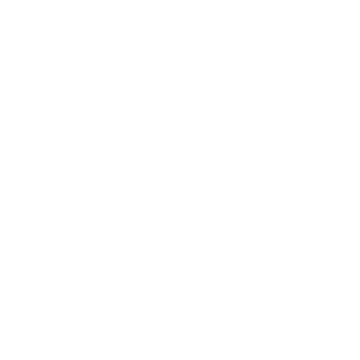

<IPython.core.display.Javascript object>


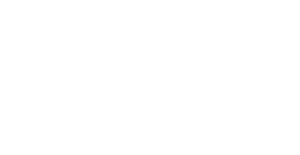

In [28]:
ppx, ppy = 0.02924, 0.02688 #Pixel pitches in x and y [mm]
plot_tracks = 3             #Plot the first 3 events
connect_hits = True         #Connects the hits
min_nop = 7                 #Plot only events that include 7 planes

#Create a figure object
xlim,ylim,zlim = 1023*ppx,511*ppy,6*20 #Dimensions of the detector
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')  #Create 3d Axes
ax._axis3don = False            #... but invisible
#ax.set_box_aspect((3,3,3))      #Define aspect ratio
ax.set_xlim3d(0,xlim)           #Axis limits in x
ax.set_ylim3d(0,ylim)           #Axis limits in y
ax.set_zlim3d(0,zlim)     
x = np.arange(0,1025*0.02924,512*0.02924)
y = np.arange(0,1024*0.02688,512*0.02688)
X, Y = np.meshgrid(x,y)
Z = np.ndarray((len(y),len(x)))
Z.fill(0)

#Draw the planes
for plane in range(7):
    Z.fill(plane*20)
    ax.plot_surface(X,Y,Z,alpha=.1,color='black')

plot_counter = 0
#Plot the hits
for event in range(len(hit_data)):
    
    #Plot only events with the minimum amount of planes specified
    if (hit_data[event]['number_of_planes'] < min_nop): continue
        
    x_data, y_data, z_data = [], [], []
    
    for plane in range(7):
        
        #Skip over empty hits
        if (hit_data[event][plane]["XC"] == -1): continue
        
        #Put everything else into plottable arrays
        x_data.append(ppx*hit_data[event][plane]["XC"])
        y_data.append(ppy*hit_data[event][plane]["YC"])
        z_data.append(plane*20)

        ax.scatter3D(x_data,y_data,alpha=.7,color='black',marker='.')
        
        # OPTIONAL: Connect dots for Better visibility of Tracks
        if connect_hits:
            ax.plot(x_data,y_data,z_data, linewidth=.5)#, color='grey')
        
    plot_counter+=1
    if plot_counter > plot_tracks: break
    

Next, the processed data is used to get a nice overview over some properties of the data

In [ ]:
# container
holes=[[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]]#holes[number of holes][n-plane-event]
holes_sum = [0,0,0,0,0,0,0]
n_p_e = [0,0,0,0,0,0,0] #number of n-plane-events
hits = [0,0,0,0,0,0,0] #number of hits per plane

#definition to exclude zeros from start and beginning of a list_line
def clear_seq(list):
    while list[-1] == 1:
        list.pop(-1)
    while list[0] == 1:
        list.pop(0)


for event in range(len(hit_data)):

    ### count number of n-plane-events and the number of hits per plane
    n_p_e[hit_data[event]["number_of_planes"]-1] +=1
    #check which planes fired
    for i in range(7):
        if hit_data[event][i]["XC"] != -1:
            hits[i] +=1
        

    ### count the holes total (depending on the number of involved planes)

    # look in events with high number >=2 of involved planes (n-plane-events) 
    if hit_data[event]["number_of_planes"] >= 2:

        npe = hit_data[event]["number_of_planes"]
        seq=[0,0,0,0,0,0,0]
        # look through every plane, if there is a hole
        for i in range(7):
            #-1 signs a plane without a hit
            if hit_data[event][i]["XC"] == -1:
                #now a hole is marked as 1 in the sequence 
                seq[i]= 1
        #clear the beginning and end of the sequence, for example [1,0,0,0,0,0,1] -> [0,0,0,0,0], since gaps at the beginning and at the end are not part of the sequnce of hitted planes
        clear_seq(seq)
        num_holes = sum(seq)

        # if at least one hole is there
        if num_holes > 0:
            holes_sum[npe-1] +=1
            if num_holes == 1:
                holes[0][npe-1] += 1
            elif num_holes == 2:
                holes[1][npe-1] += 1
            elif num_holes == 3:
                holes[2][npe-1] += 1


Now we plot the number of n-plane-events (events in which n planes registered a hit) and we look at events, where the sequnce of firing planes is interrupted by a gap (plane, which did not fire).

In [ ]:
plane = np.arange(1, 8)
# holes
#differentiate different hole numbers
hole_1 = np.array([0, holes[0], holes[1], holes[3], holes[6], holes[8], 0])#holes[0]
hole_2 = np.array([0, 0, holes[2], holes[4], holes[7],0, 0])#holes[1]
hole_3 = np.array([0, 0, 0, holes[5], 0, 0, 0])#holes[2]

#total number of holes
# sum_hole_1= sum(holes[0])
# sum_hole_2= sum(holes[1])
# sum_hole_3= sum(hole[2])


####################################################################### plotting
plt.figure(figsize=(14, 10))
plt.yscale("log")
plt.grid(which="both", axis="both")
plt.errorbar(plane, n_p_e, xerr=0.5, fmt='k', elinewidth=1.5, lw=0, capsize=3, capthick=1.5)
plt.xlabel("Number of traversed planes", fontsize=18)
plt.ylabel("Number of events", fontsize=18)
plt.title("Number of measured measured multi-plane-events", fontsize=24)
plt.tick_params(axis='both', labelsize=18)
#plt.legend(fontsize=18)
plt.show()


# plotting HOLES
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 8))
ax1.set_yscale("log")
ax1.grid(which="both", axis="both")
ax1.errorbar(plane, n_p_e,xerr=0.5, fmt='k',elinewidth=1.5, lw=0, capsize=3, capthick=1.5, label= "Measured number of n-p-e")
ax1.errorbar(plane, holes,xerr=0.5, fmt='b', elinewidth=1.5, lw=0, capsize=3, capthick=1.5, label= "Number of events with gaps")

ax1.set_xlabel("number of traversed planes", fontsize=18)
ax1.set_ylabel("mean rate $[1/s]$", fontsize=18)
ax1.tick_params(axis='both', labelsize=18)
#ax1.set_title("Mean rate of measured multi-plane-events, considering holes")
ax1.legend()#(fontsize=16)

ax2.errorbar(plane, holes/(n_p_e+0.00000000001), xerr=0.5,fmt='k',
             elinewidth=1.5, lw=0, capsize=3, capthick=1.5)
ax2.grid(which="both", axis="both")
ax2.set_xlabel("number of traversed planes", fontsize=18)
ax2.set_ylabel("Ratio of events with gaps to all measured events", fontsize=18)
ax2.tick_params(axis='both', labelsize=18)
#ax2.set_title("Ratio of events with gaps to total rate of n-plane-events")
plt.show()


# plotting MORE ON HOLES
plt.figure(figsize=(14, 10))
plt.grid(which="both", axis="both")
plt.errorbar(plane[1:6], holes[1:6], xerr=0.5,fmt='k', elinewidth=1.5, lw=0, capsize=6, capthick=1.5, label= "Total number of holes")
plt.errorbar(plane[1:6], holes[0][1:6],xerr=0.5,fmt='r',elinewidth=1.5, lw=0, capsize=3, capthick=1.5, label= "number of 1 hole events")
plt.errorbar(plane[1:6], holes[1][1:6],xerr=0.5, fmt='b',elinewidth=1.5, lw=0, capsize=3, capthick=1.5, label= "number of 2 hole events")
plt.errorbar(plane[1:6],holes[2][1:6], xerr=0.5,fmt='green',elinewidth=1.5,lw=0,capsize=3, capthick=1.5, label= "number of 3 hole events")

plt.xlabel("number of traversed planes")
plt.ylabel("Number of holes")
# plt.title("Mean rate of holes")
plt.legend()
plt.show()


# plotting_TOTAL_HITS


plt.figure(figsize=(14, 10))
plt.grid(which="both", axis="both")
plt.errorbar(plane-1, hits, xerr=0.5, fmt='k',
             elinewidth=1.5, lw=0, capsize=3, capthick=1.5)
plt.xlabel("Plane", fontsize=18)
#plt.ylabel("Mean rate $[1/s]$", fontsize=18)
plt.ylabel("Counts", fontsize = 18)
plt.tick_params(axis='both', labelsize=18)
plt.title("Number of hits per plane", fontsize=24)
# plt.legend()
plt.show()

Now, the angular distribution and fit quality is examined:

In [ ]:
##container to store plot information
Phi =  np.array([])
Chi2red =  np.array([])
Phi4,Phi5,Phi6,Phi7 = np.array([]),np.array([]),np.array([]),np.array([])

chi2red = 10 ###############   choose chi2red cut for the data visualisation


# select an event(run over all events)
for event in range(len(hit_data)):

    #check that the vent has at least 4 involved planes
    if hit_data[event]["number_of_planes"] >= 4:

        #check, if chi2red < 10, to justify that the fit of the track in this event is good
        if hit_data[event]["chi2red"] <= chi2red:

            #save chi2red for good tracks in list
            Chi2red = np.append(Chi2red,hit_data[event]["chi2red"])

            #extract the distances out of the two track point (tp1 and tp2) given
            d_x = hit_data[event]["tp2"][0]-hit_data[event]["tp1"][0]
            d_y = hit_data[event]["tp2"][1]-hit_data[event]["tp1"][1]
            d_z = hit_data[event]["tp2"][2]-hit_data[event]["tp1"][2]
            d_t = np.sqrt(d_x**2 + d_y**2)

            #calculate angle of the track
            phi = np.arctan(d_t/d_z)*360/(2*np.pi)
            Phi = np.append(Phi,phi)

            # look at the angles for events with different numbers of involved planes
            if hit_data[event]["number_of_planes"]==4:
                Phi4 = np.append(Phi4,phi)
            if hit_data[event]["number_of_planes"]==5:
                Phi5 = np.append(Phi5,phi)
            if hit_data[event]["number_of_planes"]==6:
                Phi6 = np.append(Phi6,phi)
            if hit_data[event]["number_of_planes"]==7:
                Phi7 = np.append(Phi7,phi)


#######################---PLOTS   PLOTS   PLOTS   PLOTS---#############################

plt.hist(Phi,bins= 14 ,range=(0,28), color= "darkblue")#, label="Selected tracks, $\chi^2_{red} \leqslant$ "+str(chi2red))
plt.title("Angular distribution of 4 or more plane events with $\chi^2_{red} \leqslant$ "+str(chi2red))
plt.xlabel("Zenith angle [°]")
plt.ylabel("Counts")
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))
plt.hist(Chi2red, bins=20, color="darkblue")#, label="Selected tracks, $\chi^2_{red}$ in range "+str(chi11)+" to "+str(chi12))+" and "+str(chi21)+" to "+str(chi22)
#plt.hist(Chi,range=(0,100), bins=50, label="Selected tracks, $\phi$ in range "+str(phi111)+" to "+str(phi142))
plt.title("$\chi^2_{red}$-distribution of 4 and more plane events with cut at $\chi^2_{red} =$ "+str(chi2red), fontsize = 24)# in range "+str(chi11)+" to "+str(chi12))
plt.xlabel("$\chi^2_{red}$", fontsize = 18)
plt.ylabel("Counts", fontsize = 18)
plt.tick_params(axis='both', labelsize=18)
#plt.legend()
plt.show()

plt.figure(figsize=(12, 10))
plt.hist(([Phi7,Phi6,Phi5,Phi4]), bins= 14 ,range=(0,28),label=("7 planes","6 or more planes","5 or more planes","4 or more planes" ), color= ("darkred","darkgreen","darkorange","darkblue")
, histtype="barstacked")#, weights=(np.ones(len(Phi7)),np.ones(len(Phi6))/2,np.ones(len(Phi5))/3,np.ones(len(Phi4))/4))
plt.title("Angular distribution of n-plane-eventswith, $\chi^2_{red}\leq$"+str(chi2red), fontsize = 24)#, $\chi^2_{red}$ in range "+str(chi11)+" to "+str(chi12), fontsize = 24)
plt.xlabel("Zenith angle [°]", fontsize = 18)
plt.ylabel("Counts", fontsize = 18)
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize = 18)